In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import glob
import xarray as xr
import cartopy.crs as ccrs
import sys
import copy
%matplotlib inline
from matplotlib.gridspec import GridSpec
import warnings
import matplotlib as mpl
import matplotlib.transforms as mtransforms

sys.path.append('/global/homes/j/jhollo/repos/climate_util')
import climate_toolbox as ctb
from climate_artist import horizontal_slice as plthor
from climate_artist import horizontal_slice as pltvert

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

print('done')

done


In [35]:
# ========== read data ==========

# --- pm

use_75day_ens = False
use_90day_ens = False
use_90day_ens_fromIC = False
use_data_release = True
use_m1x_ens = False
if(sum([int(use_75day_ens), int(use_90day_ens), int(use_90day_ens_fromIC), int(use_m1x_ens), int(use_data_release)]) != 1):
    raise RuntimeError

if(use_90day_ens):
    lv_loc = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/extra_LIMVAR_outputs_for_hsw_paper/ens_members'  
    lv_label = '90DayLimvarEns'
if(use_75day_ens):
    lv_loc = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/extra_LIMVAR_outputs_for_hsw_paper/ens_members_75DayDelay'
    lv_label = '75DayLimvarEns'
if(use_90day_ens_fromIC):
    lv_loc = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/extra_LIMVAR_outputs_for_hsw_paper/ens_members'
    lv_loc_true = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/pertlim_ic_ens/for_hsdwpaperfigs_11.10.23'
    lv_label = '90DayLimvarEnsFromIC'
if(use_m1x_ens):  
    lv_loc = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/tmp2'
    lv_label = 'mass1XLimvarEns'
if(use_data_release):
    lv_loc = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_ens_latlon'
    lv_label = 'release030123LimvarEns'

hv_loc = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members_latlon'
out    = '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/hswPaperFigs'
vars   = ['AOD', 'U']
N = 5

print('done')

done


In [40]:
print('opening data...')

if(lv_label == 'mass1XLimvarEns'):
    ens_lv = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}*mass1.00X*.h2*'.format(lv_loc, i+1)))[0])[vars] for i in range(N)]
elif(lv_label == 'release030123LimvarEns'):
    ens_lv = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}/*.h2*regrid*'.format(lv_loc, i+1)))[0])[vars] for i in range(N)]
else:
    ens_lv = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}/run/*.h2*regrid*'.format(lv_loc, i+1)))[0])[vars] for i in range(N)]
if(lv_label == '90DayLimvarEnsFromIC'):
    ens_lv_true = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}/run/*.h2*regrid*'.format(lv_loc_true, i+1)))[0])[vars] for i in range(N)]

ens_hv = [xr.open_dataset(sorted(glob.glob('{}/ens0{}/*.h2*'.format(hv_loc, i+1)))[0])[vars] for i in range(N)]

# --- reassign time dim to day integer, slice to day 300
print('converting time coordinates...')
for i in range(len(ens_lv)):
    print('...ens{}...'.format(i+1))
    ens_lv[i] = ens_lv[i].assign_coords(time=ctb.time2day(ens_lv[i].time))
    ens_lv[i] = ens_lv[i].sel(time = slice(0, 300))
    ens_hv[i] = ens_hv[i].assign_coords(time=ctb.time2day(ens_hv[i].time))
    ens_hv[i] = ens_hv[i].sel(time = slice(0, 300))
    if(lv_label == 'release030123LimvarEns'):
        ens_lv[i]   = ens_lv[i].sel(time=ens_lv[i].time % 2 == 0)
    if(lv_label == '90DayLimvarEnsFromIC'):
        ens_lv_true[i] = ens_lv_true[i].assign_coords(time=(ctb.time2day(ens_lv_true[i].time) + 90))
        ens_lv_true[i] = ens_lv_true[i].sel(time = slice(0+90, 300+90))
    if(lv_label == 'mass1XLimvarEns'):
        overwrite_odddays = False
        tmpfile = '/pscratch/sd/j/jhollo/tmp/{}_processed_ens{}.nc'.format(lv_label, i+1)
        try:
            if(overwrite_odddays): raise FileNotFoundError
            ens_lv[i] = xr.open_dataset(tmpfile)
            print('read ens0{} from file...'.format(i+1))
        except FileNotFoundError:
            print('converting 1-day means to 2-days means for {}'.format(lv_label))
            ens_lv_odddays   = copy.deepcopy(ens_lv[i])
            ens_lv_odddays   = ens_lv_odddays.assign_coords(time= ens_lv_odddays.time + 1)
            ens_lv_odddays   = ens_lv_odddays.sel(time=ens_lv_odddays.time % 2 == 0)
            ens_lv[i]        = ens_lv[i].sel(time=ens_lv[i].time % 2 == 0)
            ens_lv[i]['U']   = (ens_lv_odddays['U'] + ens_lv[i]['U']) / 2
            ens_lv[i]['AOD'] = (ens_lv_odddays['AOD'] + ens_lv[i]['AOD']) / 2
            ens_lv[i].to_netcdf(tmpfile)
            print('wrote ens0{} to file...'.format(i+1))

overwrite=False
try:
    if(overwrite): raise FileNotFoundError
    ensmean_lv = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}_paperversion.nc'.format(lv_label))
    ensmean_hv = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_hv.nc')
    if(lv_label == '90DayLimvarEnsFromIC'):
        ensmean_lv_true = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_lv_true_{}_paperversion.nc'.format(lv_label))
    ensmean_read = True
except FileNotFoundError:
    print('building ensmean zeros...')
    ensmean_lv = xr.zeros_like(ens_lv[0])
    ensmean_hv = xr.zeros_like(ens_hv[0])
    if(lv_label == '90DayLimvarEnsFromIC'):
        ensmean_lv_true = xr.zeros_like(ens_lv_true[0])
    ensmean_read = False

lat  = ens_lv[0]['lat']
lon  = ens_lv[0]['lon']
nlat, nlon = len(lat), len(lon)
time_lv = ens_lv[0].time
time_lv_true = ens_lv[0].time
time_hv = ens_hv[0].time

print('done')

opening data...
converting time coordinates...
...ens1...
...ens2...
...ens3...
...ens4...
...ens5...
building ensmean zeros...
done


In [41]:
# ========== compute ensemble mean ==========

if(ensmean_read):
    pass
else:
    print('computing ensemble mean...')
    for var in vars:
        print('var {}...'.format(var))
        for i in range(N):
            print('...ens0{}...'.format(i+1))
            ensmean_lv[var] = ensmean_lv[var] + ens_lv[i][var]
            ensmean_hv[var] = ensmean_hv[var] + ens_hv[i][var]
            if(lv_label == '90DayLimvarEnsFromIC'):
                ensmean_lv_true[var] = ensmean_lv_true[var] + ens_lv_true[i][var]
    ensmean_lv = ensmean_lv / N
    ensmean_hv = ensmean_hv / N
    if(lv_label == '90DayLimvarEnsFromIC'):
        ensmean_lv_true = ensmean_lv_true / N
    
    print('writing ens mean to file...')
    ensmean_lv.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}_paperversion.nc'.format(lv_label))
    ensmean_hv.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_hv.nc')
    if(lv_label == '90DayLimvarEnsFromIC'):
        ensmean_lv_true.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_lv_true_{}_paperversion.nc'.format(lv_label))

print('done')

computing ensemble mean...
var AOD...
...ens01...
...ens02...
...ens03...
...ens04...
...ens05...
var U...
...ens01...
...ens02...
...ens03...
...ens04...
...ens05...
writing ens mean to file...
done


In [42]:
# ========== reduce variables ==========

print('reducing U...')
U_lv = [0] * 5
U_hv = [0] * 5
if(lv_label == '90DayLimvarEnsFromIC'):
    U_lv_true = [0] * 5
    
U_range = slice(-5, 35)
U_lev   = 133
weights = xr.DataArray(np.cos(np.deg2rad(lat)), coords={'lat':lat}).sel(lat=U_range)

for i in range(N):
    print('...ens0{}...'.format(i+1))
    U_lv[i] = ens_lv[i].sel({'lev':U_lev}, method='nearest').mean('lon')
    U_lv[i] = U_lv[i]['U'].sel({'lat':U_range})
    U_lv[i] = U_lv[i].weighted(weights).mean('lat')
    
    U_hv[i] = ens_hv[i].sel({'lev':U_lev}, method='nearest').mean('lon')
    U_hv[i] = U_hv[i]['U'].sel({'lat':U_range})
    U_hv[i] = U_hv[i].weighted(weights).mean('lat', 'lon')
    
    if(lv_label == '90DayLimvarEnsFromIC'):
        U_lv_true[i] = ens_lv_true[i].sel({'lev':U_lev}, method='nearest').mean('lon')
        U_lv_true[i] = U_lv_true[i]['U'].sel({'lat':U_range})
        U_lv_true[i] = U_lv_true[i].weighted(weights).mean('lat')
        
print('done')

reducing U...
...ens01...
...ens02...
...ens03...
...ens04...
...ens05...
done


In [43]:
print('retrieving AOD...')

AOD_lv = [ens_lv[i]['AOD'] for i in range(5)]
AOD_hv = [ens_hv[i]['AOD'] for i in range(5)]
if(lv_label == '90DayLimvarEnsFromIC'):
    AOD_lv_true = [ens_lv_true[i]['AOD'] for i in range(5)]
    
print('done')

retrieving AOD...
done


In [44]:
print('reducing ensmean U...')

Uem_lv = ensmean_lv.sel({'lev':U_lev}, method='nearest').mean('lon')
Uem_lv = Uem_lv['U'].sel({'lat':U_range})
Uem_lv = Uem_lv.weighted(weights).mean('lat')
    
Uem_hv = ensmean_hv.sel({'lev':U_lev}, method='nearest').mean('lon')
Uem_hv = Uem_hv['U'].sel({'lat':U_range})
Uem_hv = Uem_hv.weighted(weights).mean('lat', 'lon')

if(lv_label == '90DayLimvarEnsFromIC'):
    Uem_lv_true = ensmean_lv_true.sel({'lev':U_lev}, method='nearest').mean('lon')
    Uem_lv_true = Uem_lv_true['U'].sel({'lat':U_range})
    Uem_lv_true = Uem_lv_true.weighted(weights).mean('lat')

print('done')

reducing ensmean U...
done


creating figure...


/tmp/ipykernel_168516/1607669453.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


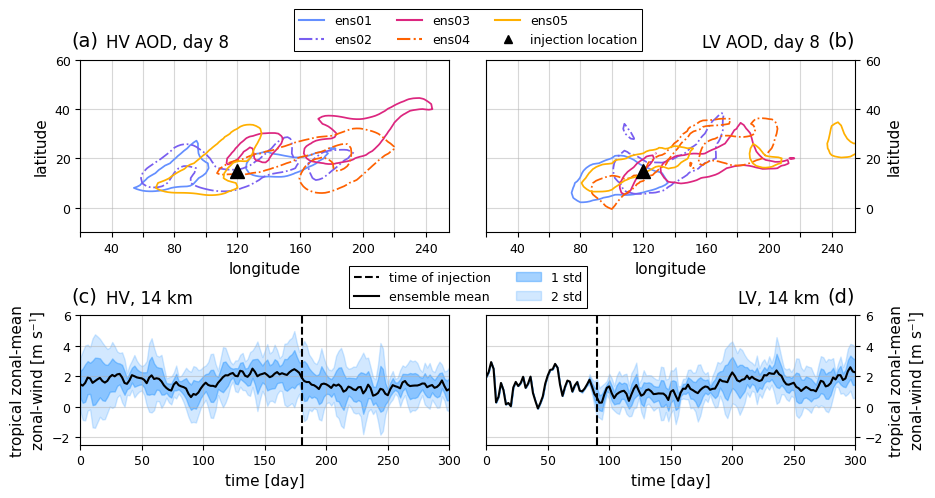

In [45]:
# ==================== plot ===========

if(lv_label == '90DayLimvarEnsFromIC'):
    LV_TO_PLOT = 'lv_true'
else:
    LV_TO_PLOT = 'lv'

plotting_day = 8
erupt_day_hv = 180
erupt_day_lv = 90
AOD_time_hv  = erupt_day_hv + plotting_day  # day to plot AOD
AOD_time_lv  = erupt_day_lv + plotting_day  # day to plot AOD
U_time_lv    = erupt_day_lv                  # day of injection in U
U_time_hv    = erupt_day_hv                  # day of injection in U

if(lv_label == '75DayLimvarEns'):
    # because this ensemble only has outputs for odd-numbered days...
    erupt_day_lv = 75
    AOD_time_lv  = erupt_day_lv + (plotting_day+1)
    U_time_lv = erupt_day_lv

if(LV_TO_PLOT == 'lv'):
    AOD_lv_var = AOD_lv
    Uem_lv_var = Uem_lv
    U_lv_var   = U_lv
elif(LV_TO_PLOT == 'lv_true'):
    AOD_lv_var = AOD_lv_true
    Uem_lv_var = xr.concat([Uem_lv.sel(time=slice(0, 88)), Uem_lv_true.sel(time=slice(90, 300))], dim='time')
    Uem_lv_var = Uem_lv_var.sel(time=Uem_lv_var.time % 2 == 0)
    U_lv_var   = [xr.concat([U_lv[i].sel(time=slice(0, 88)), U_lv_true[i].sel(time=slice(90, 300))], dim='time') for i in range(N)]
    U_lv_var   = [U_lv_var[i].sel(time=U_lv_var[i].time % 2 == 0) for i in range(N)]


#clev_c = np.array([0.25, 0.5, 0.75]) + 1e-3
clev_c = np.array([0.6])

LON, LAT = np.meshgrid(lon, lat)
#colors = ['r', 'b', 'g', 'm', 'c']
colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
linestyles = ['-', '-.', '-', '-.', '-']
ens_alpha = 0

if(U_lev == 133):
    levlabel = '14 km'
else:
    lavlabel = '{} hPa'.format(U_lev)
    
Ucolor = 'dodgerblue'

latlim      = [-10, 60]
lonlim      = [25, 255]
lonticks    = np.arange(20, 260, 20)

# =====================================

    
print('creating figure...')

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[2, 1.5], 
              hspace=0.55, wspace=0.1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# ----------- plot ens members as colored contours

for i in range(N):
    var = AOD_hv[i].sel(time=AOD_time_hv)
    ax1.contour(lon, lat, var, levels=clev_c, linewidths=1.25, 
                colors=colors[i], linestyles=linestyles[i])
ax1.plot([120], [15], 'k^', ms=10)

ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_ylim(latlim)
ax1.set_xlim(lonlim)
ax1.set_xticks(lonticks)
ax1.grid(alpha=0.5)
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax1.tick_params(left=True, right=False, labelleft=True, labelright=False)

plt.text(.07, 1.051, 'HV AOD, day {}'.format(plotting_day), ha='left', va='bottom', 
         transform=ax1.transAxes, fontsize=BIG_SIZE)

# ---

for i in range(N):
    var = AOD_lv_var[i].sel(time=AOD_time_lv)
    ax2.contour(lon, lat, var, levels=clev_c, linewidths=1.25, 
                colors=colors[i], linestyles=linestyles[i])
    ax2.plot([0,0], [0,0], color=colors[i], ls=linestyles[i], 
         label='ens0{}'.format(i+1))
ax2.plot([120], [15], 'k^', ms=10) 
ax2.plot([120], [180], 'k^', ms=6, label='injection location') #dummy

ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude') 
ax2.set_ylim(latlim)
ax2.set_xlim(lonlim)
ax2.set_xticks(lonticks)
ax2.grid(alpha=0.5)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax2.tick_params(left=False, right=True, labelleft=False, labelright=True)
ax2.yaxis.set_label_position("right")

leg = ax2.legend(loc='upper right', bbox_to_anchor=(0.44, 1.33), 
                 ncol=3, fancybox=False, framealpha=1, shadow=False)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.75)

plt.text(0.905, 1.051, 'LV AOD, day {}'.format(plotting_day), ha='right', va='bottom', 
         transform=ax2.transAxes, fontsize=BIG_SIZE)
    

# ----------- plot ens members as U time series

pstd_lv = xr.zeros_like(Uem_lv_var)
pstd_hv = xr.zeros_like(Uem_hv)
for i in range(N):
    ax4.plot(time_lv, U_lv_var[i], color='k', alpha=ens_alpha)
    pstd_lv = pstd_lv + ((U_lv_var[i] - Uem_lv_var)**2).values
    ax3.plot(time_hv, U_hv[i], color='k', alpha=ens_alpha)
    pstd_hv = pstd_hv + ((U_hv[i] - Uem_hv)**2).values
pstd_lv = pstd_lv / (N)
pstd_lv = np.sqrt(pstd_lv)
pstd_hv = pstd_hv / (N)
pstd_hv = np.sqrt(pstd_hv)

ax3.plot(time_hv, Uem_hv, color='k', lw=1.5)
ax3.fill_between(time_hv, Uem_hv-pstd_hv, Uem_hv+pstd_hv, color=Ucolor, alpha=0.4)
ax3.fill_between(time_hv, Uem_hv-2*pstd_hv, Uem_hv+2*pstd_hv, color=Ucolor, alpha=0.2)
ax3.grid(alpha=0.5)
ax3.set_ylabel('tropical zonal-mean\nzonal-wind ' + r'[m s$^{-1}$]')
ax3.set_xlabel('time [day]')
ax3.set_xlim([0, 300])
ax3.axvline(U_time_hv, color='k', ls='--')
plt.text(.07, 1.061, 'HV, {}'.format(levlabel), ha='left', va='bottom', 
         transform=ax3.transAxes, fontsize=BIG_SIZE)

ax4.axvline(U_time_lv, color='k', ls='--', label='time of injection', zorder=99)
ax4.plot(time_lv, Uem_lv_var, color='k', lw=1.5, label='ensemble mean')
ax4.fill_between(time_lv, Uem_lv_var-pstd_lv, Uem_lv_var+pstd_lv, color=Ucolor, 
                 alpha=0.4, label='1 std')
ax4.fill_between(time_lv, Uem_lv_var-2*pstd_lv, Uem_lv_var+2*pstd_lv, color=Ucolor, 
                 alpha=0.2, label = '2 std')
ax4.grid(alpha=0.5)
ax4.set_ylabel('tropical zonal-mean\nzonal-wind ' + r'[m s$^{-1}$]')
ax4.set_xlabel('time [day]')
ax4.set_xlim([0, 300])
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.text(0.905, 1.061, 'LV, {}'.format(levlabel), ha='right', va='bottom', 
         transform=ax4.transAxes, fontsize=BIG_SIZE)

leg = ax4.legend(bbox_to_anchor=(0.29, 1.43), ncol=2, fancybox=False, 
                 framealpha=1, shadow=False)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.75)

#ax3.set_ylim(-6,4)
#ax4.set_ylim(-6,4)
#ax3.set_ylim(-2,8)
#ax4.set_ylim(-2,8)
ax4.set_ylim(-2.5, 6)
ax3.set_ylim(-2.5, 6)

# ========================================

axs = [ax1, ax2, ax3, ax4]
axlabs = ['(a)', '(b)', '(c)', '(d)']
for i in range(len(axs)):
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    if(i ==0 or i == 2): pos = [0.05, 1]
    else:                pos = [1, 1]
    axs[i].text(pos[0], pos[1], axlabs[i], transform=axs[i].transAxes + trans,
               fontsize=BIGGER_SIZE, va='bottom', fontfamily='sans-serif')

plt.subplots_adjust(hspace=0)
fig.tight_layout()
plt.savefig('figs/ensemble_plumes_paper_{}.pdf'.format(lv_label), dpi=300, bbox_inches='tight')
plt.show()